# Neural Networks using Keras

## Preparing the Keras framework

Our goal is to tune the Apple Store NN for multi-class classification. We need to make several decisions when configuring our NN and focus on finding the optimal parameters for the
 - number of hidden layers
 - number of neurons in hidden layers
 - activation functions
 - type of weight initialization
 - learning rate and momentum
 - optimizer
 - size of batch
 - number of epochs
 - regularization (dropout)



In a first Part of this Notebook we will use Grid Search for Hyperparameter Tuning.

Then in a second Part we will use Keras-Tuner

In [ ]:
# Setting up the environment: import standard libraries and load the data. 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#This package provides utilities for Keras, such as modified callbacks, data genereators, encoder, etc.
#from keras.utils import np_utils    # it does not work now with the actual version of tensorflow and keras
from tensorflow.keras import utils   # this works


##Use case: app rating analysis
NNs often **solve classification problems with many classes**. To illustrate their functioning in a context that is more related to NLP examples,we introduce the data set concerned with app ratings. The **original data is available on Kaggle**. There, you also find a data dictionary with some information on the variables. However, the variable names are rather self-explanatory. A cleaned version of the data is available in this folder. The easiest way for you is to use the cleaned version but feel very free to play around with the version on Kaggle. You can find a Python script that starts from the original data and goes through a couple of pre-processing operations to produce the version we use below (**app_store_dpp.py**).

In [ ]:
# Load dataset and set app name as index

app = pd.read_csv("https://raw.githubusercontent.com/murpi/wilddata/master/quests/AppleStore_prep.csv", 
                  index_col=False, sep='\t', encoding='utf-8')
app = app.set_index('track_name')
app.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7197 entries, PAC-MAN Premium to Escape the Sweet Shop Series
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   size_bytes                     7197 non-null   float64
 1   price                          7197 non-null   float64
 2   rating_count_tot               7197 non-null   float64
 3   sup_devices.num                7197 non-null   float64
 4   ipadSc_urls.num                7197 non-null   float64
 5   lang.num                       7197 non-null   float64
 6   vpp_lic                        7197 non-null   float64
 7   currency_USD                   7197 non-null   int64  
 8   cont_rating_12+                7197 non-null   int64  
 9   cont_rating_17+                7197 non-null   int64  
 10  cont_rating_4+                 7197 non-null   int64  
 11  cont_rating_9+                 7197 non-null   int64  
 12  prime_genre_Boo

So **36 columns**, **one of which is the target variable**. We consider the **user rating as our target** and will try to set up a NN that predict the rating from the app characteristics including information on its price, genre, etc.

Let's have a quick look at the target variable. Note that we that we have reduced the number of rating classes compared to the original version of the data on Kaggle (see app_store_dpp.py for details).  


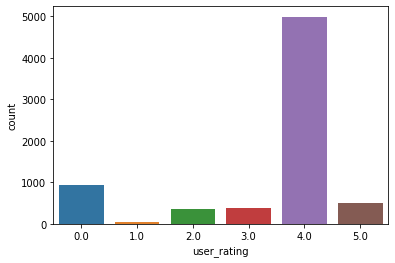

In [ ]:
# Inspect the target
import seaborn as sns
sns.countplot(x=app.user_rating);

In [ ]:
app["user_rating"]

track_name
PAC-MAN Premium                                       4.0
Evernote - stay organized                             4.0
WeatherBug - Local Weather, Radar, Maps, Alerts       4.0
eBay: Best App to Buy, Sell, Save! Online Shopping    4.0
Bible                                                 4.0
                                                     ... 
Kubik                                                 4.0
VR Roller-Coaster                                     4.0
Bret Michaels Emojis + Lyric Keyboard                 4.0
VR Roller Coaster World - Virtual Reality             4.0
Escape the Sweet Shop Series                          5.0
Name: user_rating, Length: 7197, dtype: float64

In [ ]:
# Prepare the target variable
# LabelEncoder() transforms a string vector to a num vector
encoder = LabelEncoder()
#fit label encoder
encoder.fit(app["user_rating"])
#transform and return encoded labels
encoder.transform(app["user_rating"])

#in this case it is not necessary, the labels are already numeric in appropriate range of 0...5


array([4, 4, 4, ..., 4, 4, 5])

In [ ]:
#dummy_y = np_utils.to_categorical( encoder.transform(app["user_rating"])).astype(int)
#dummy_y

In [ ]:
# do the one_hot_encoding directly with the target data
dummy_y = utils.to_categorical((app["user_rating"])).astype(int)
dummy_y

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

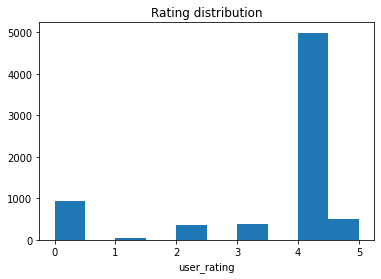

(5037, 35)
(5037, 6)


In [ ]:
plt.hist(dummy_y.argmax(axis=1))
plt.xlabel('user_rating')
plt.title('Rating distribution')
plt.show();

# Let's split our data set

#Seed function is used to save the state of a random function, so that it can generate same random numbers on multiple executions of the code on the same machine or on different machines (for a specific seed value)
seed=42

X = app.iloc[:,:-1].values
y = dummy_y

# Keep in mind that this data set is already standardized, which leads to a leakage of information from train set to test set
# When you are working with a dataset, make sure you standardize the variables in test set according to the parameters of the train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)
    
print (X_train.shape)
print(y_train.shape) 
#X.head(5)

## Preparing the Keras framework


Today we will revise the architecture of our basic neural network and look more into the tuning of hyperparameters.



In [ ]:
nb_units = 128
# And finally the outout layer
nb_classes = y.shape[1]

In [ ]:
# Import Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adamax


model = Sequential()
model.add(Dense(nb_units, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed), input_shape=(X.shape[1],)))
#model.add(Dropout(0.1))
model.add(Dense(nb_units, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
#model.add(Dropout(0.1))
model.add(Dense(nb_classes, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 21,894
Trainable params: 21,894
Non-trainable params: 0
_________________________________________________________________


In [ ]:

batch_size = 56 #1 for online SGD

# example: start trining the model up until 30 epochs and plot the training loss values and validation loss values against number of epochs.
epochs = 30


model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])
# Fit the model
story = model.fit(X_train, y_train, #name model differently
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_test, y_test))
                    #validation_split=0.33)#validation_data=(X_test, y_test)


In [ ]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax1.plot(story.history['accuracy'])
    ax1.plot(story.history['val_accuracy'])
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train_accuracy', 'test_accuracy'], loc='best')
    ax1.set_title('Accuracy evolution during NN training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during NN training')
    plt.show()


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

Test loss: 0.9580324292182922
Test accuracy: 0.7074074149131775


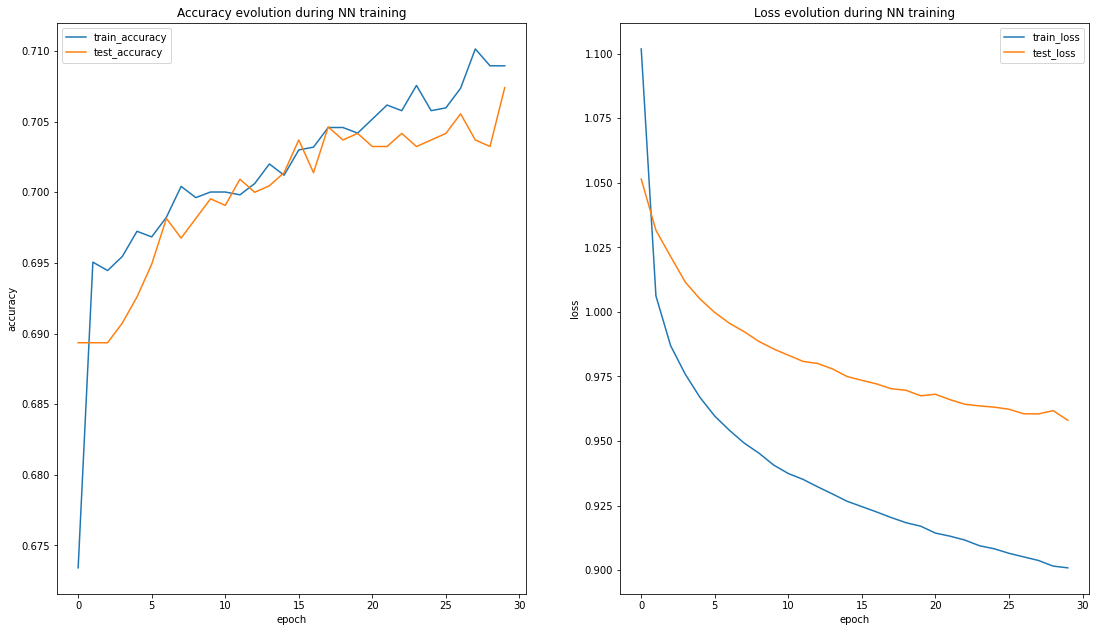

In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])
show_history(story)

# Part 1: Hyperparameter optimization with Keras

We will start with the old-fashioned way with Scikit Learn and will first show you an example of how to use GridSearch with two groups of hyperparameters: batches/epochs and optimizer algorithms. 

In [ ]:
#import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers

In [ ]:
#We will use the architecture we had before and wrap it into the function called 'network ' (or whatever you want to call it)

def network():
    
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    model.add(Dense(6, activation='softmax',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    
    model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy']) #nothing changes here

    return model

# Now we will plug it into Keras Classifier Wrapper 
model = KerasClassifier(build_fn=network, verbose=0)

In [ ]:
# Let's define the grid search parameters
batchsize = [32, 64, 128, 256, 512]
epochs = [10,30,60,70]

In [ ]:
#Set the grid
param_grid = dict(batch_size=batchsize, epochs=epochs)# setting a dictionary to store the results
param_grid 

{'batch_size': [32, 64, 128, 256, 512], 'epochs': [10, 30, 60, 70]}

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=3) #parallelization, here using all processors
results = grid.fit(X_train, y_train) #remember that we don't want to use the test set in CV
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.709748 using {'batch_size': 32, 'epochs': 60}


In [ ]:
best_epochs = results.best_params_.get('epochs')
best_batch_size = results.best_params_.get('batch_size')

In [ ]:
def optim_gen (optimizer='SGD', activation='relu', nodes=128, learning_rate=0.01, momentum=0, init_mode='zero', dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(nodes, activation=activation, bias_initializer='zeros', kernel_initializer=init_mode, input_shape=(X.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(nodes, activation=activation, bias_initializer='zeros', kernel_initializer=init_mode))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax',kernel_initializer=init_mode))
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

In [ ]:
#Let's now take this knowledge and apply it to our optimizers tuning

model = KerasClassifier(build_fn=optim_gen, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# define the grid search parameters
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizers) # setting a dictionary to store the results
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.695255 using {'optimizer': 'SGD'}


In [ ]:
best_optimizer = results.best_params_.get('optimizer')

Now continue using Grid Search to tune the Learning Rate and Momentum:

In [ ]:
model = KerasClassifier(build_fn=optim_gen, epochs=best_epochs, batch_size=best_batch_size, optimizer = best_optimizer, verbose=0)
#model = KerasClassifier(build_fn=optim_opt, epochs=60, batch_size=32, verbose=0)
# define the grid search parameters

learning_rate = [0.1, 0.01, 0.001, 0.0001]
momentum = [0.0, 0.1, 0.2, 0.4, 0.8]
param_grid = dict(learning_rate=learning_rate, momentum=momentum) # setting a dictionary to store the results
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.695255 using {'learning_rate': 0.1, 'momentum': 0.0}


In [ ]:
best_learning_rate = results.best_params_.get('learning_rate')
best_momentum = results.best_params_.get('momentum')

Use Grid Search to tune the Network Weight Initialization:

In [ ]:
model = KerasClassifier(build_fn=optim_gen, epochs=best_epochs, batch_size=best_batch_size, optimizer = best_optimizer,
                        learning_rate=best_learning_rate, momentum=best_momentum, verbose=0)

# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.711932 using {'init_mode': 'glorot_normal'}


In [ ]:
best_init_mode = results.best_params_.get('init_mode')

Use Grid Search to tune the Neuron Activation Function


In [ ]:
model = KerasClassifier(build_fn=optim_gen, epochs=best_epochs, batch_size=best_batch_size, optimizer = best_optimizer,
                        learning_rate=best_learning_rate, momentum=best_momentum, init_mode=best_init_mode, verbose=0)

# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.708557 using {'activation': 'tanh'}


In [ ]:
best_activation = results.best_params_.get('activation')

Use Grid Search to tune Dropout Regularization

In [ ]:
model = KerasClassifier(build_fn=optim_gen, epochs=best_epochs, batch_size=best_batch_size, optimizer = best_optimizer,
                        learning_rate=best_learning_rate, momentum=best_momentum, init_mode=best_init_mode,
                        activation=best_activation, verbose=0)

# define the grid search parameters
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.707961 using {'dropout_rate': 0.0}


In [ ]:
best_dropout_rate = results.best_params_.get('dropout_rate')

Use Grid Search to tune the Number of Neurons in the Hidden Layer

In [ ]:
model = KerasClassifier(build_fn=optim_gen, epochs=best_epochs, batch_size=best_batch_size, optimizer = best_optimizer,
                        learning_rate=best_learning_rate, momentum=best_momentum, init_mode=best_init_mode,
                        activation=best_activation, dropout_rate = best_dropout_rate, verbose=0)

# define the grid search parameters
nodes = [16, 32, 35, 64,128, 256]
param_grid = dict(nodes=nodes)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (remember these are the results on the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.709549 using {'nodes': 128}


In [ ]:
best_nodes = results.best_params_.get('nodes')

In [ ]:
# summarize grid search results:
print(f'optimizer: {best_optimizer}')
print(f'epochs: {best_epochs}')
print(f'batch_size: {best_batch_size}')
print(f'init mode: {best_init_mode}')
print(f'nodes: {best_nodes}')
print(f'activation: {best_activation}')
print(f'learning_rate: {best_learning_rate}')
print(f'momentum: {best_momentum}')
print(f'dropout_rate: {best_dropout_rate}')


optimizer: SGD
epochs: 60
batch_size: 32
init mode: glorot_normal
nodes: 128
activation: tanh
learning_rate: 0.1
momentum: 0.0
dropout_rate: 0.0
